# Anomaly Detection on Synthetic Data
In this notebook, we ...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_anomaly_AABB.ipynb)

In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

SYN_DATA_PATH = Path(r"../data/synthetic/")
random_state = None

In [2]:
def init():
    IN_COLAB = 'google.colab' in sys.modules

    if(IN_COLAB):
        !git clone https://github.com/berni-lehner/structural_health_monitoring.git
        sys.path.insert(0,"/content/structural_health_monitoring/src")
        sys.path.insert(0,"/content/structural_health_monitoring/data")    
    else:
        sys.path.insert(0,"../src")
        sys.path.insert(0,"../data")

    try:
        from zippeekiyay import namelist
    except ImportError or ModuleNotFoundError:
        print('installing zippee-ki-yay...')
        !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

        from zippeekiyay import namelist

In [3]:
def init_data():
    from DataDownloader import DataDownloader as ddl
    
    url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"

    start_time = time.perf_counter()
    dl_succeed = ddl.download_and_unpack(url, SYN_DATA_PATH, cache=True)
    end_time = time.perf_counter()
    print(f"time passed: {end_time-start_time:.2f} s")
    print(f"downloading successful: {dl_succeed}")    

In [4]:
# initialize environment, paths, etc...
init()
#...and download raw data if not already downloaded
init_data()


from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)

from bench_utils import (
    classification_benchmark,
    get_aa_experiment,
    aabb_classification_benchmark,
    extract_metrics)

time passed: 4.78 s
downloading successful: True


In [5]:
from data_utils import load_preprocessed_data

target_col='y_radius'


F_MAX = 24000
N_LOG_BINS = 66

In [6]:
df, fb = load_preprocessed_data(SYN_DATA_PATH, target_col=[target_col], f_max=F_MAX, n_log_bins=N_LOG_BINS)

df.info()

files: 34152
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         34152 non-null  float32
 1   1         34152 non-null  float32
 2   2         34152 non-null  float32
 3   3         34152 non-null  float32
 4   4         34152 non-null  float32
 5   5         34152 non-null  float32
 6   6         34152 non-null  float32
 7   7         34152 non-null  float32
 8   8         34152 non-null  float32
 9   9         34152 non-null  float32
 10  10        34152 non-null  float32
 11  11        34152 non-null  float32
 12  12        34152 non-null  float32
 13  13        34152 non-null  float32
 14  14        34152 non-null  float32
 15  15        34152 non-null  float32
 16  16        34152 non-null  float32
 17  17        34152 non-null  float32
 18  18        34152 non-null  float32
 19  19        34152 non-null  float32
 20  20        34152

In [7]:
cnt = Counter(df[target_col])
cnt

Counter({0.0: 990,
         0.3125: 975,
         0.625: 971,
         0.9375: 980,
         1.25: 978,
         1.5625: 968,
         1.875: 978,
         2.1875: 979,
         2.5: 979,
         2.8125: 978,
         3.125: 986,
         3.4375: 972,
         3.75: 973,
         4.0625: 976,
         4.375: 979,
         4.6875: 976,
         5.0: 977,
         6.666999816894531: 981,
         8.333000183105469: 972,
         10.0: 973,
         12.0: 969,
         14.0: 978,
         16.0: 980,
         18.0: 976,
         20.0: 974,
         22.0: 975,
         24.0: 980,
         26.0: 973,
         28.0: 983,
         30.0: 977,
         32.0: 967,
         34.0: 971,
         36.0: 976,
         38.0: 964,
         40.0: 968})

## ignore defects with unrealistically small size

In [8]:
#ignore_radius = 4.0 # this is justified according to material properties
ignore_radius = 2.5 # this is justified according to material properties


df_normal =  df[df[target_col]==0.0]
df_anomaly = df[df[target_col]>ignore_radius]

Xpos = df_normal.drop(columns=[target_col]).values
Xneg = df_anomaly.drop(columns=[target_col]).values

In [9]:
X, y = CreateAnomalyData(Xpos, Xneg)

### Anomaly Detection-specific scoring

In [10]:
scoring = get_anomaly_scoring()

In [11]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

## Create CV splits for each model instance separately

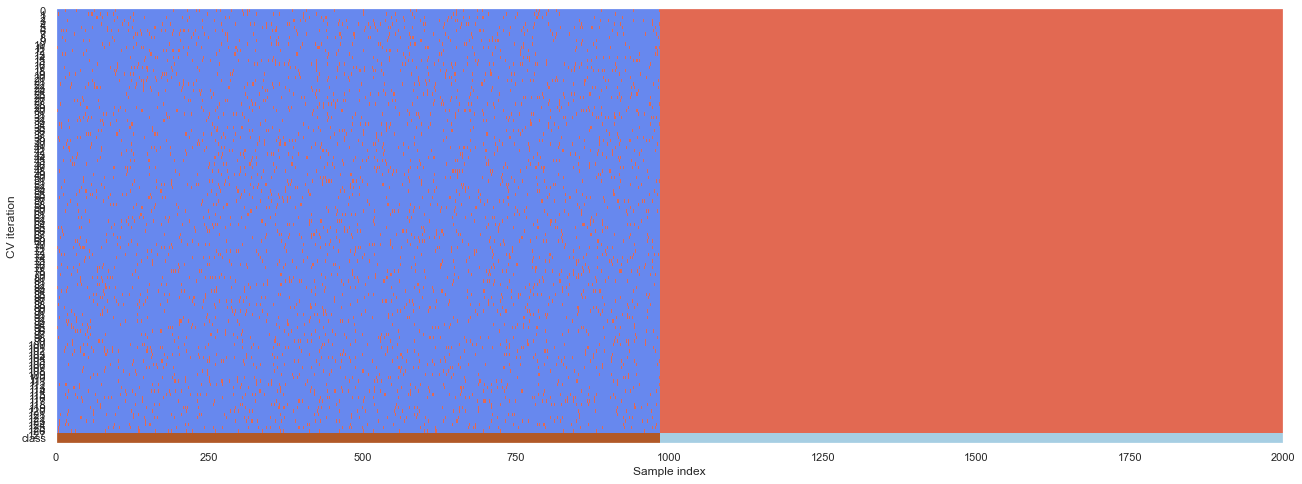

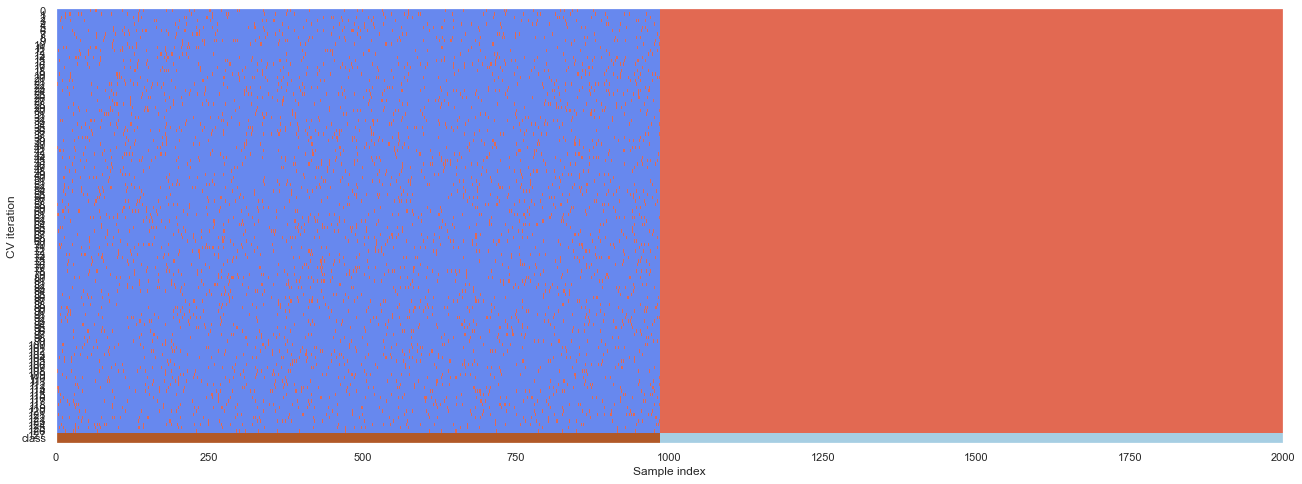

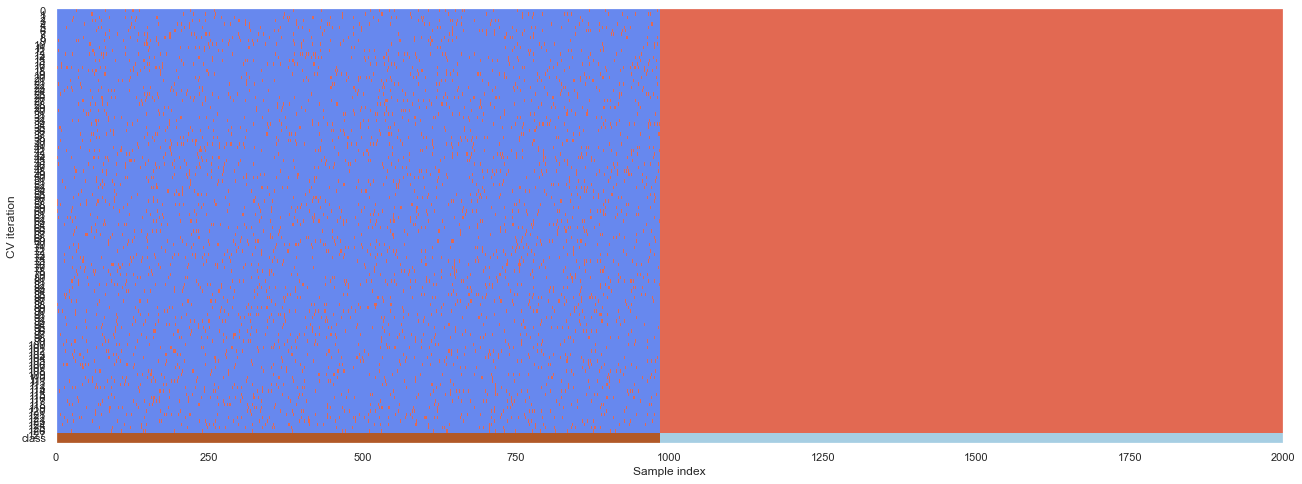

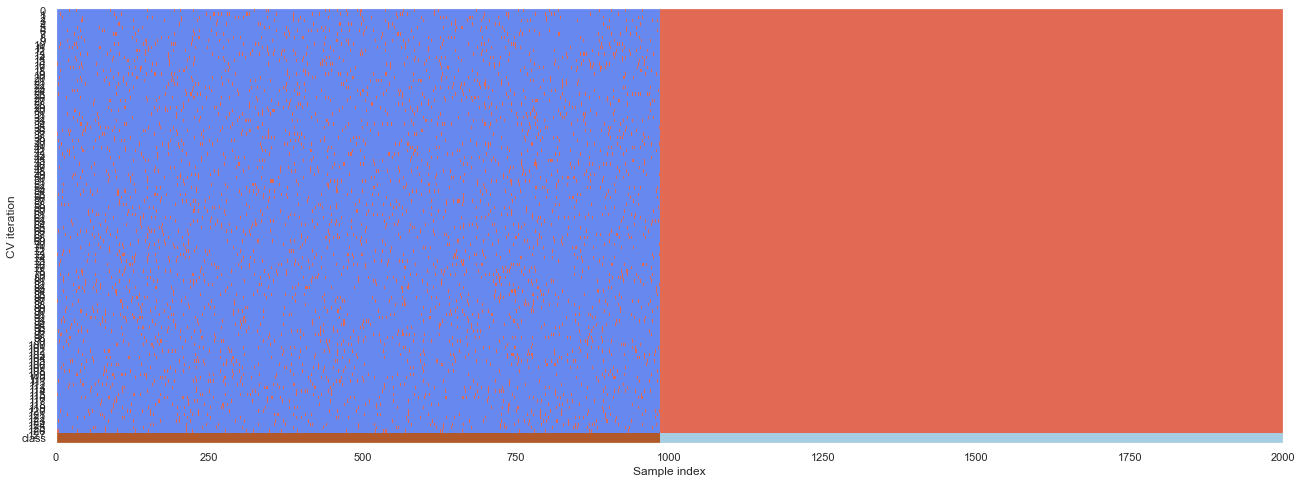

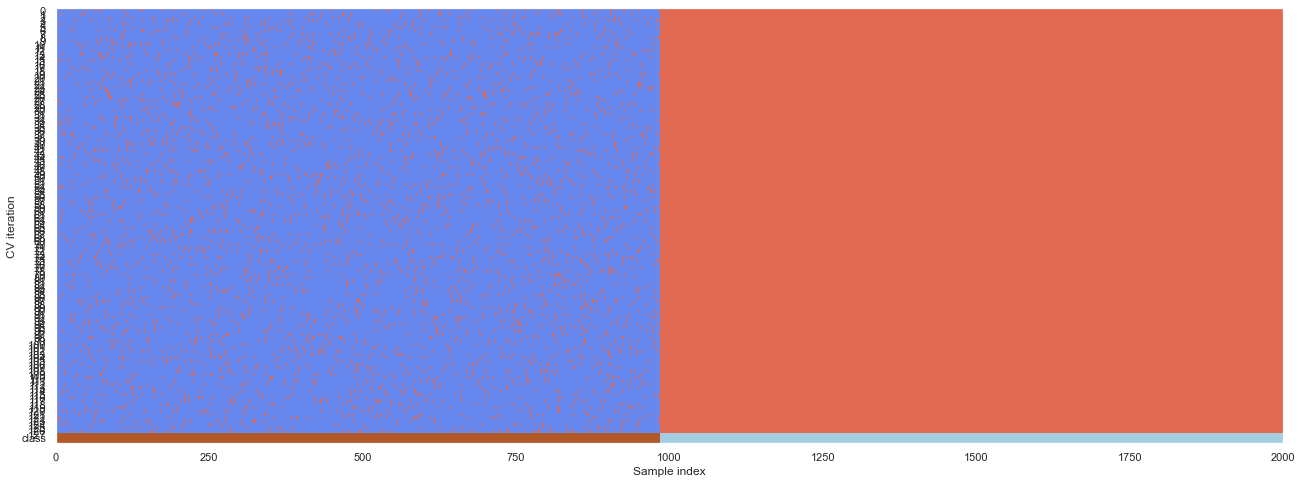

In [12]:
n_repeats = 5
cv = RepeatedAnomalyShuffleSplit(Xpos, Xneg, n_splits=128, test_size=.05, n_repeats=n_repeats, random_state=random_state)

for cv_ in cv:
    fig, ax = plt.subplots()
    ax = plot_cv_indices(cv_, X, y, ax)
    ax.set(xlim=[0, 2000])

# AA-BB Testing

In [13]:
estimator = IsolationForest(contamination=0.03, n_estimators=100)
pipeline = Pipeline([('est', estimator)])

if_pipelines = get_aa_experiment(estimator=pipeline, n_repeats=n_repeats, name="IsolationForest")

In [14]:
estimator = OneClassSVM(gamma='scale', nu=0.005)
pipeline = Pipeline([('scaler', RobustScaler()), ('est', estimator)])

svm_pipelines = get_aa_experiment(estimator=pipeline, n_repeats=n_repeats, name="OneClassSVM")

In [15]:
estimator = EllipticEnvelope(contamination=0.15)
pipeline = Pipeline([('scaler', RobustScaler()), ('est', estimator)])

mcd_pipelines = get_aa_experiment(estimator=pipeline, n_repeats=n_repeats, name="MCD")

In [16]:
svm_pipelines

[('OneClassSVM_0',
  Pipeline(steps=[('scaler', RobustScaler()), ('est', OneClassSVM(nu=0.005))])),
 ('OneClassSVM_1',
  Pipeline(steps=[('scaler', RobustScaler()), ('est', OneClassSVM(nu=0.005))])),
 ('OneClassSVM_2',
  Pipeline(steps=[('scaler', RobustScaler()), ('est', OneClassSVM(nu=0.005))])),
 ('OneClassSVM_3',
  Pipeline(steps=[('scaler', RobustScaler()), ('est', OneClassSVM(nu=0.005))])),
 ('OneClassSVM_4',
  Pipeline(steps=[('scaler', RobustScaler()), ('est', OneClassSVM(nu=0.005))]))]

In [17]:
if_pipelines

[('IsolationForest_0',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))])),
 ('IsolationForest_1',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))])),
 ('IsolationForest_2',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))])),
 ('IsolationForest_3',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))])),
 ('IsolationForest_4',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))]))]

In [18]:
mcd_pipelines

[('MCD_0',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('est', EllipticEnvelope(contamination=0.15))])),
 ('MCD_1',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('est', EllipticEnvelope(contamination=0.15))])),
 ('MCD_2',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('est', EllipticEnvelope(contamination=0.15))])),
 ('MCD_3',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('est', EllipticEnvelope(contamination=0.15))])),
 ('MCD_4',
  Pipeline(steps=[('scaler', RobustScaler()),
                  ('est', EllipticEnvelope(contamination=0.15))]))]

In [19]:
aabb_results = aabb_classification_benchmark(X=X, y=y,
                                   models=[if_pipelines, svm_pipelines, mcd_pipelines],
                                   cv=cv,
                                   scoring=scoring,
                                   random_state=random_state)

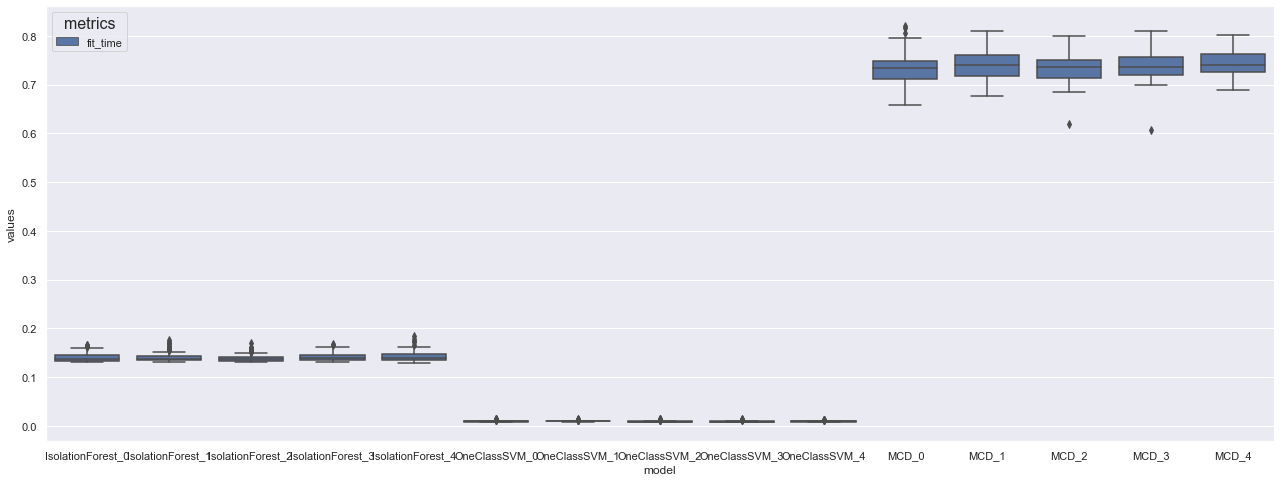

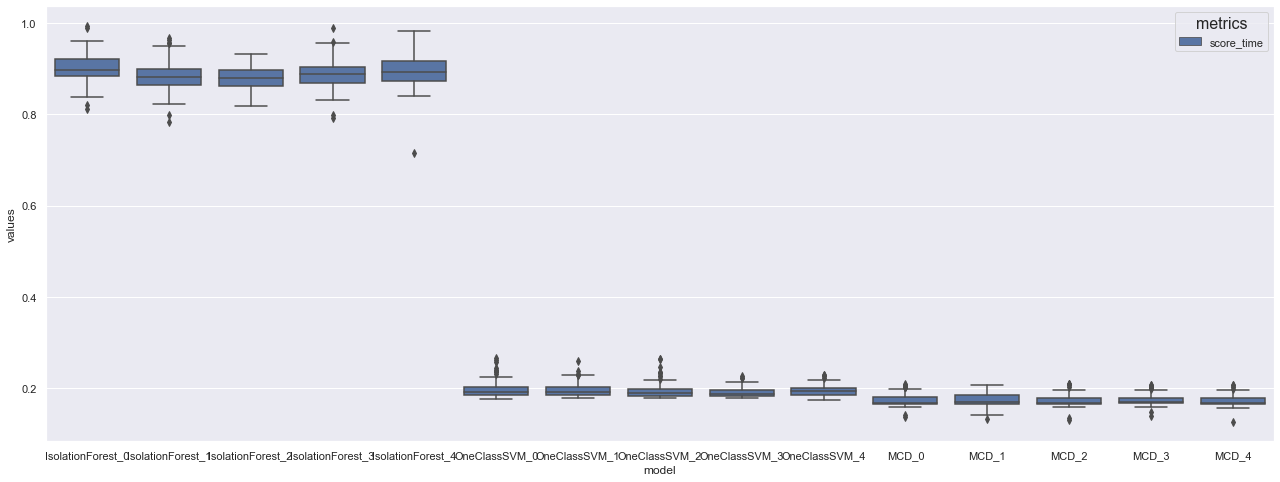

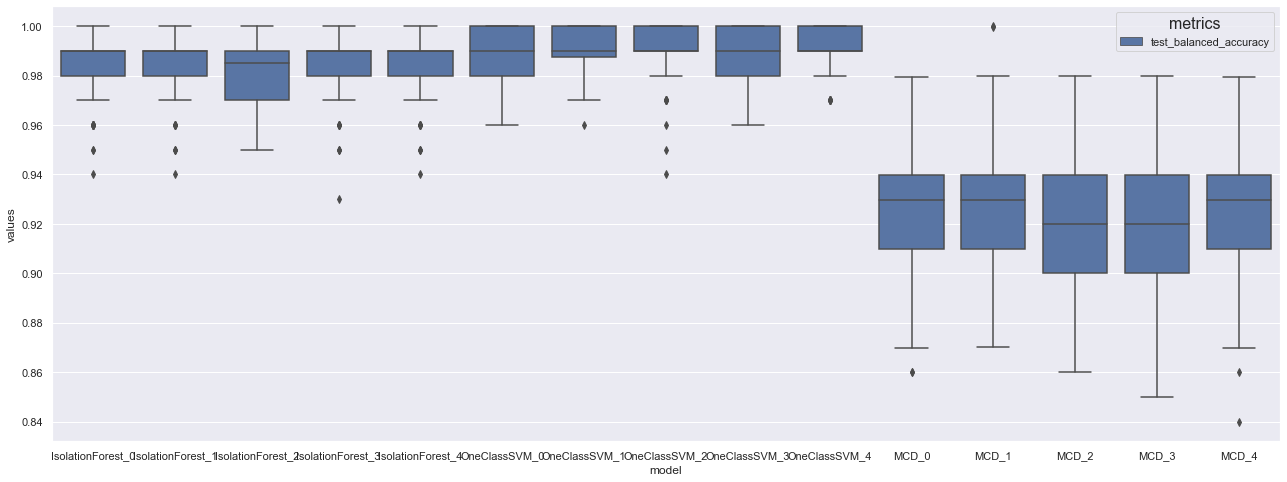

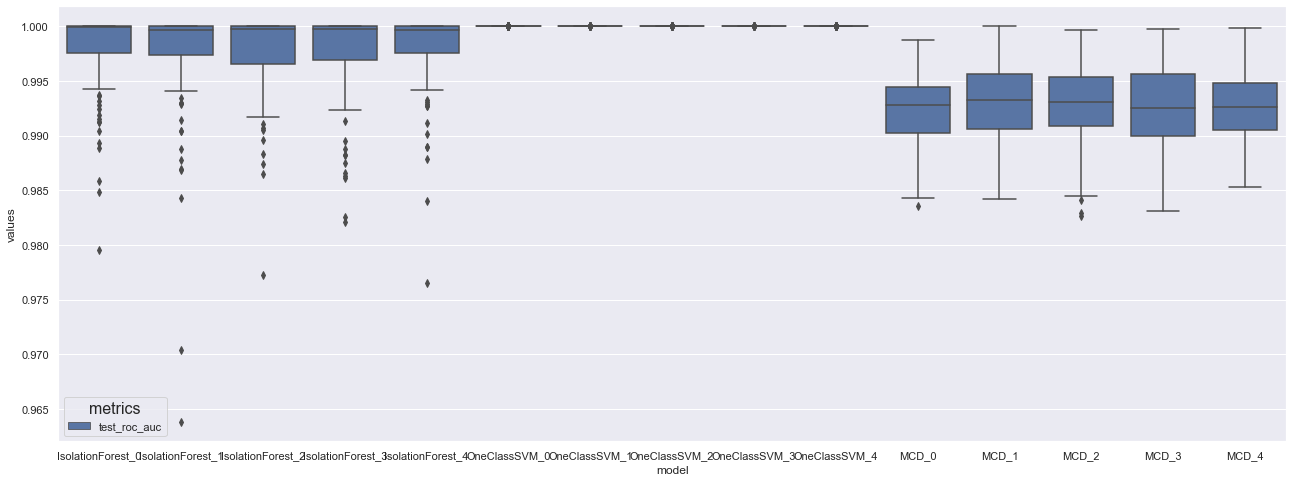

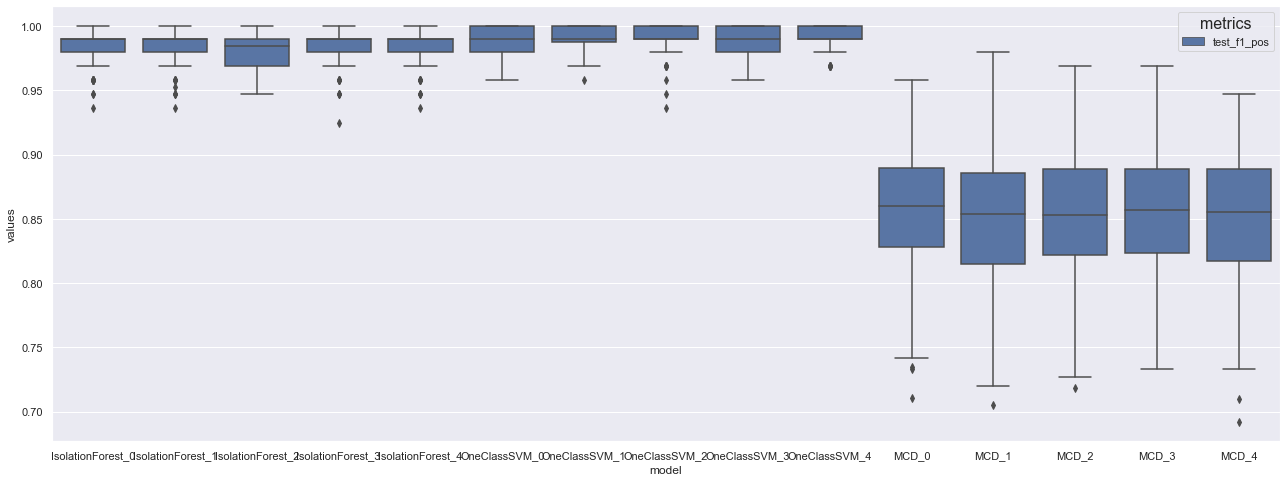

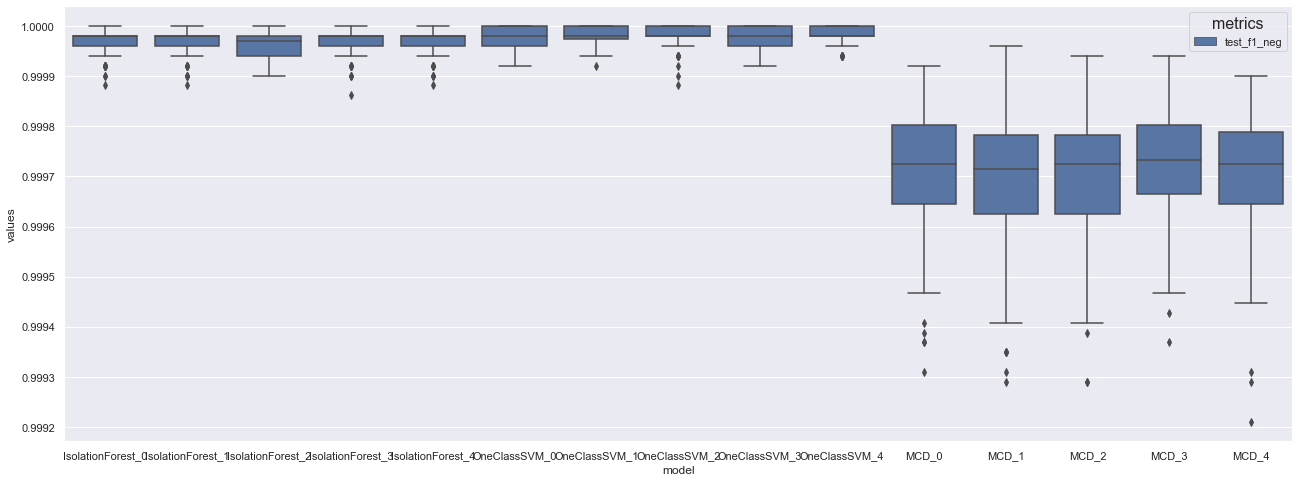

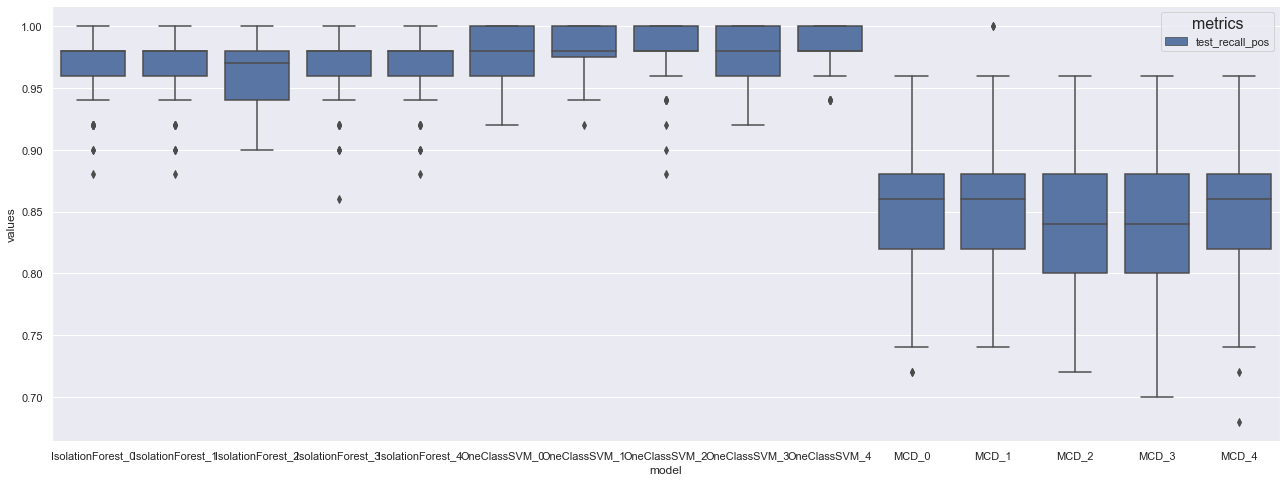

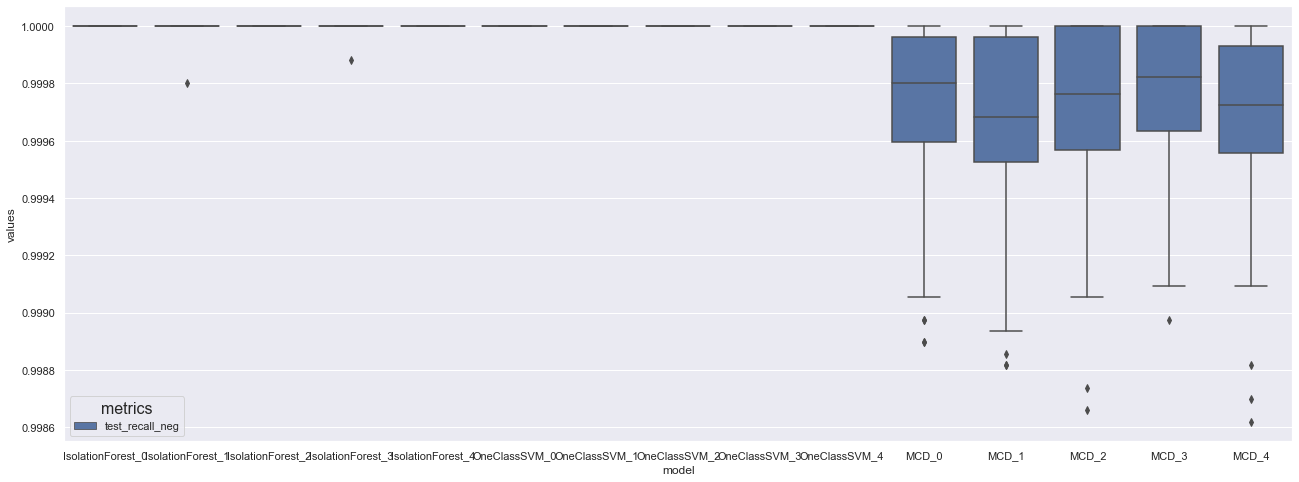

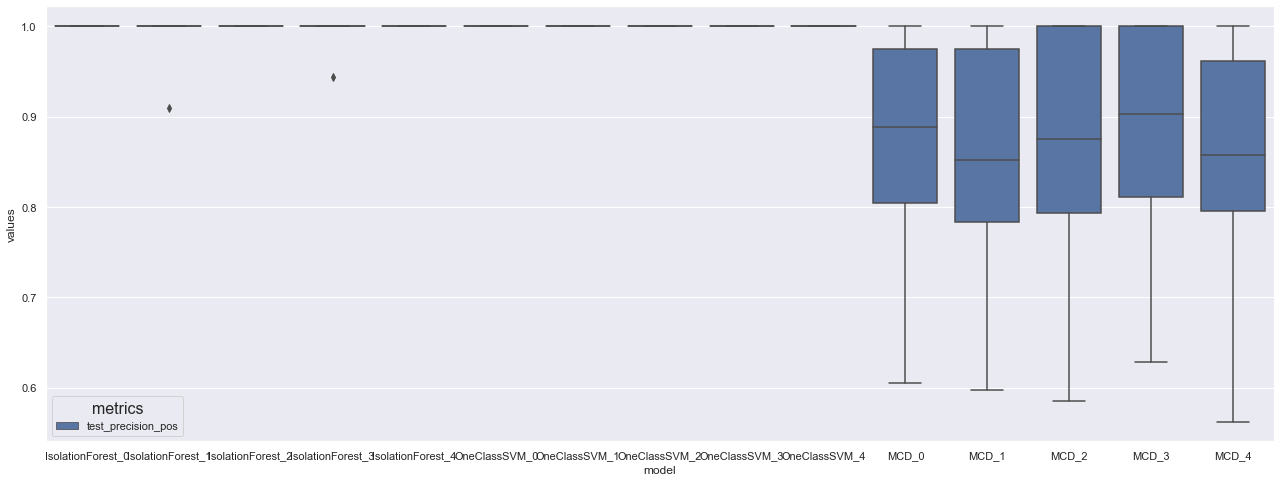

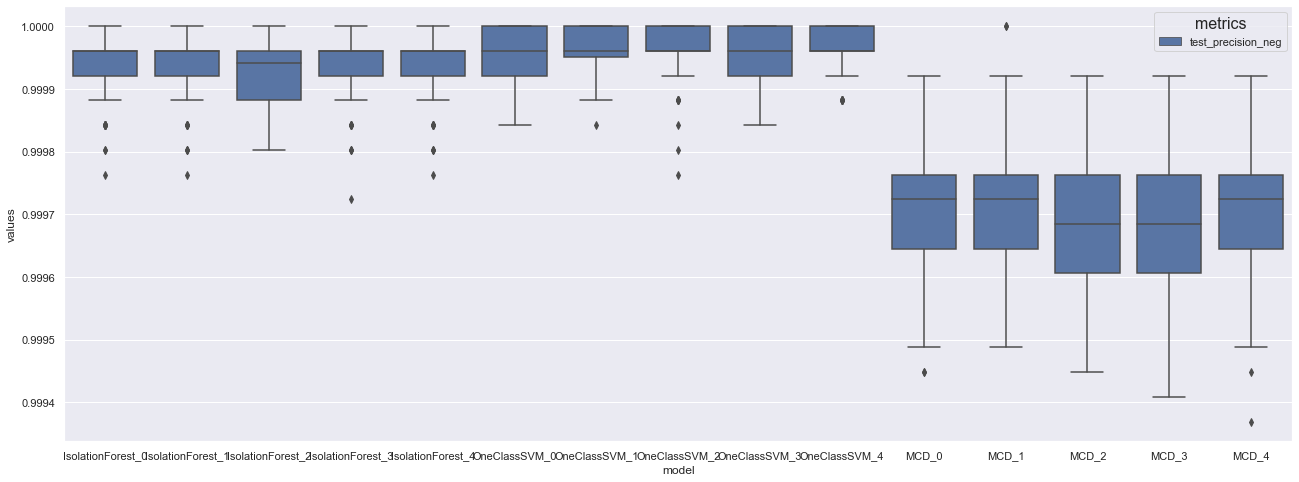

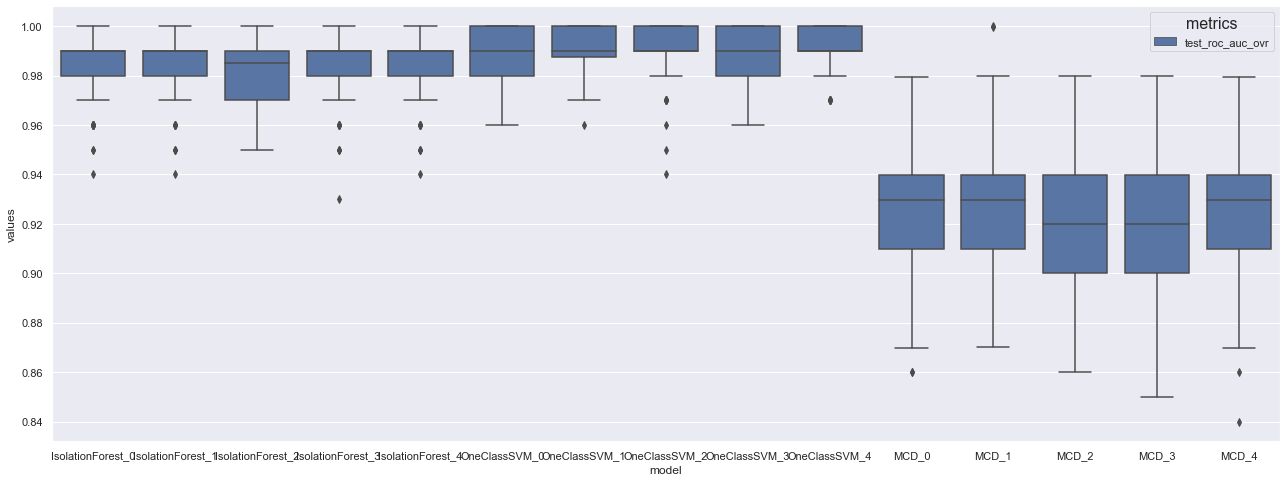

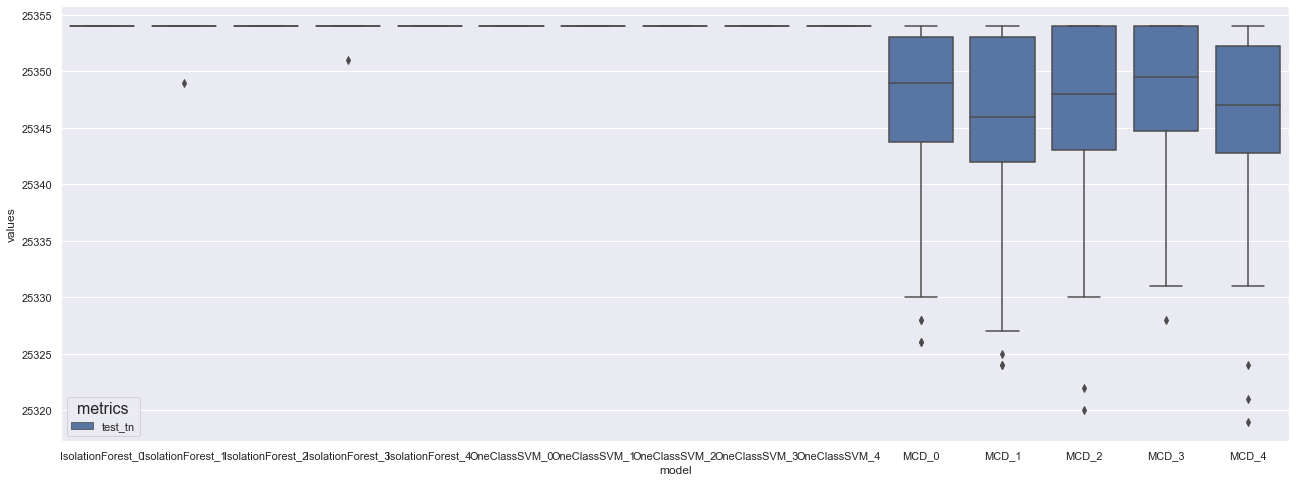

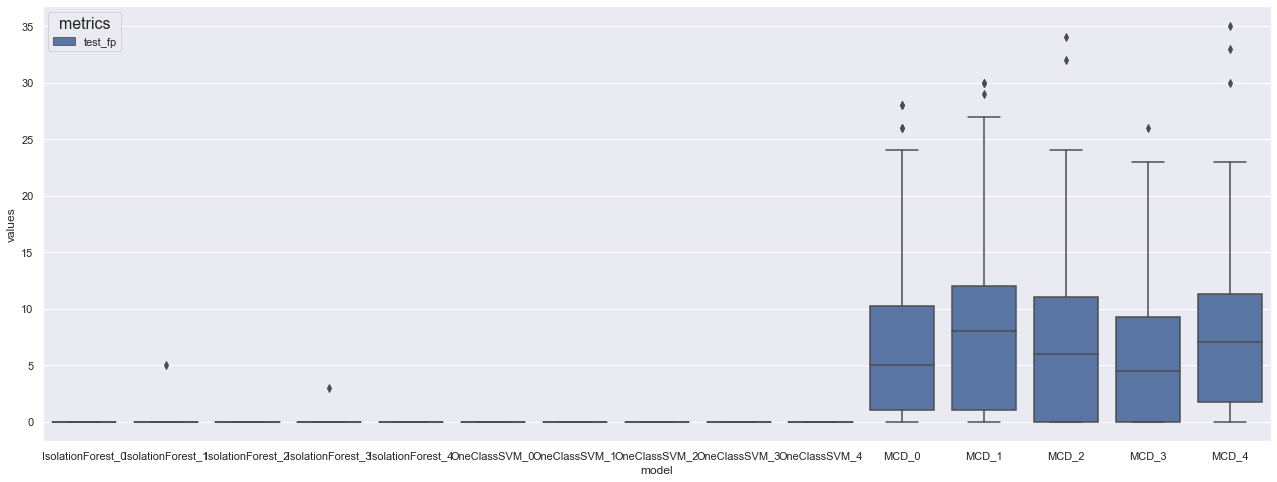

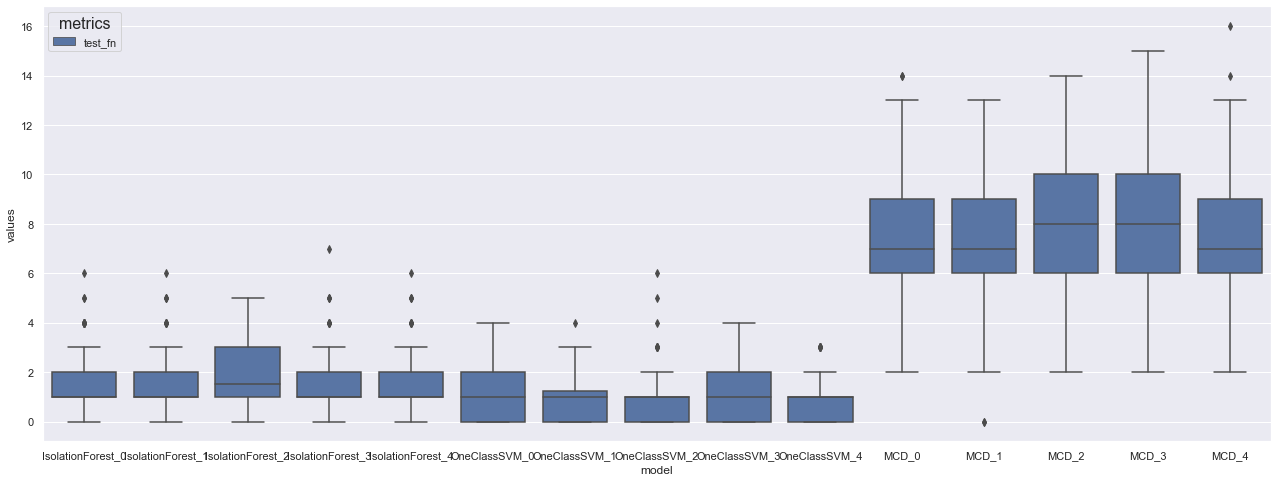

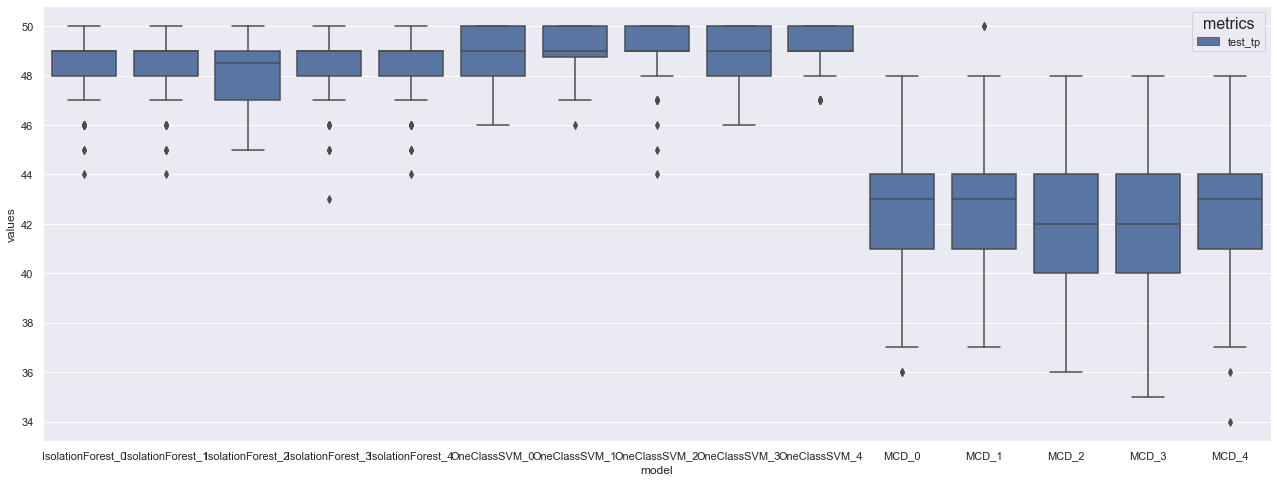

In [20]:
for key in aabb_results.columns[:-1]:
    fig = plot_metrics(extract_metrics(aabb_results, [key]))
    plt.show()